# AST Inference

In [1]:
import kagglehub

# Загружаем датасет UrbanSound с Kaggle
path = kagglehub.dataset_download("chrisfilo/urbansound8k")

print("Path to dataset files:", path)

100%|██████████| 5.61G/5.61G [01:12<00:00, 83.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1


In [2]:
%cp -r /root/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1 ./kaggle/

Ссылка на веса: https://drive.google.com/file/d/1HYZTLSZ1aqHdSnhVT_YdR9d20BxuQqXN/view?usp=sharing

In [6]:
!unzip "/content/finetuned_ast_2024_12_08.zip" -d "/content/finetuned_ast_2024_12_08"

Archive:  /content/finetuned_ast_2024_12_08.zip
  inflating: /content/finetuned_ast_2024_12_08/config.json  
  inflating: /content/finetuned_ast_2024_12_08/model.safetensors  
  inflating: /content/finetuned_ast_2024_12_08/training_args.bin  


## Загружаем модель

In [50]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, ASTFeatureExtractor
import torch

import matplotlib.pyplot as plt

class ast_model:
    def __init__(self, saved_model_path:str):
        """
        * `saved_model_path` - путь до папки с файлами для инициализации дообученной модели AST
        """

        self.model = ASTForAudioClassification.from_pretrained(saved_model_path)

        self.feature_extractor = ASTFeatureExtractor() # спектрограмма

        # with open('yamnet_classes.pickle', 'rb') as f:
        #     self.model_classes = pickle.load(f)

        self.model_classes = model_inference.config.id2label
        self.label2id = model_inference.config.label2id

        self.sample_rate = 16000

    def predict(self, wav:np.ndarray, top_n:int=5):
        """
        Делает общее предсказание для входного моно wav-файла частотой 16 кГц (необходимо для работы модели)

        * `wav` - waveform в формате `np.ndarray`
        * `top_n` - какое количество наиболее вероятных классов необходимо выдать
        """

        inputs = self.feature_extractor(wav, sampling_rate=self.sample_rate, return_tensors="pt")

        with torch.no_grad():
            outputs = self.model(**inputs).logits

        sm = torch.nn.Softmax(dim=1)

        class_probabilities = sm(outputs).numpy()[0]

        top_class_indices = np.argsort(class_probabilities)[::-1][:5]

        return [self.model_classes[i] for i in top_class_indices], np.array(class_probabilities)[top_class_indices]

    def predict_with_explain(self, wav:np.ndarray, k:int=1, top_n:int=5):
        """
        Делает общее предсказание для входного моно wav-файла частотой 16 кГц (необходимо для работы модели).
        Производит предсказания для частей входного wav-файла длиной `k` секунд для определения, какие части
        оказали наибольшее влияние

        * `wav` - waveform в формате `np.ndarray`
        * `k` - длина интервала в секундах
        * `top_n` - какое количество наиболее вероятных классов необходимо выдать
        """

        # audio, sr = librosa.load(path_to_wav_file, sr=sample_rate, mono=True)

        # Шаг 2: Расчет количества сэмплов для интервала k
        segment_samples = k * self.sample_rate

        # Шаг 3: Нарезка аудио на части длиной k
        segments = [
            wav[i:i + segment_samples]
            for i in range(0, len(wav), segment_samples)
        ]

        # Делаем паддинг для последнего сегмента
        segments[-1] = np.pad(segments[-1], (0, max(0, segment_samples - len(segments[-1]))))

        # итеративно прогоняем каждый сегмент через модель
        segments_results = []
        for segment in segments:

            # segment_tensor = tf.convert_to_tensor(segment, dtype=tf.float32)

            # Отправляем сегмент в модель
            # result = self.model(segment_tensor)

            inputs = self.feature_extractor(segment, sampling_rate=self.sample_rate, return_tensors="pt")

            with torch.no_grad():
                outputs = self.model(**inputs).logits

            sm = torch.nn.Softmax(dim=1)
            class_probabilities = sm(outputs).numpy()[0]

            segments_results.append(class_probabilities)


        segments_results = np.array(segments_results)

        # делаем предсказание для всего файла
        total_classes, total_probabilities = self.predict(wav, top_n=top_n)

        top_class_indices = [self.label2id[class_i] for class_i in total_classes]

        top_n_segments_results = segments_results[:, top_class_indices]

        # Создаём график с указанием, наиболее влияющих участков для каждого класса

        # Создание фигуры и осей
        fig, ax = plt.subplots(figsize=(10, 6))

        # Визуализация сегментов для топ-N классов
        cax = ax.imshow(
            top_n_segments_results.T,
            aspect='auto',
            interpolation='nearest',
            cmap='gray_r'
        )

        # Настройка осей
        yticks = range(0, top_n)
        ax.set_yticks(yticks)
        ax.set_yticklabels([self.model_classes[idx] for idx in top_class_indices])
        ax.set_ylim(-0.5 + np.array([top_n, 0]))  # Настройка лимитов по y

        # Добавление цветовой шкалы
        fig.colorbar(cax, ax=ax, orientation='vertical', label='Probability')

        # Возврат объекта фигуры
        return total_classes, total_probabilities, top_n_segments_results, fig

In [51]:
model_test = ast_model('/content/finetuned_ast_2024_12_08')

In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/kaggle/UrbanSound8K.csv')
df['filenames'] = '/content/kaggle/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

In [18]:
from IPython.display import Audio

for_test = df.sample()

wav_file_name = for_test['filenames'].iloc[0]
classs_true = for_test['class'].iloc[0]

print(wav_file_name, classs_true)

Audio(wav_file_name)

/content/kaggle/fold9/171406-9-0-23.wav street_music


In [40]:
import librosa

feature_extractor = ASTFeatureExtractor()

audio, sr = librosa.load(wav_file_name, sr=16000, mono=True)

model_test.predict(audio)

(['street_music', 'jackhammer', 'car_horn', 'siren', 'children_playing'],
 array([9.9997425e-01, 1.1219035e-05, 3.1846432e-06, 3.0281183e-06,
        2.7537380e-06], dtype=float32))

(['street_music', 'jackhammer', 'car_horn', 'siren', 'children_playing'],
 array([9.9997425e-01, 1.1219035e-05, 3.1846432e-06, 3.0281183e-06,
        2.7537380e-06], dtype=float32),
 array([[1.7820609e-01, 2.0324173e-04, 8.1630337e-01, 5.0686826e-03,
         3.2703942e-05],
        [6.7575406e-03, 1.8397161e-03, 9.5849037e-01, 3.1766631e-02,
         1.7992590e-05],
        [3.1236789e-01, 3.4108933e-02, 6.5074068e-01, 1.4528062e-03,
         2.6810469e-04],
        [1.5938802e-01, 1.8137250e-04, 8.4018266e-01, 6.9898524e-05,
         2.1522717e-05]], dtype=float32),
 <Figure size 1000x600 with 2 Axes>)

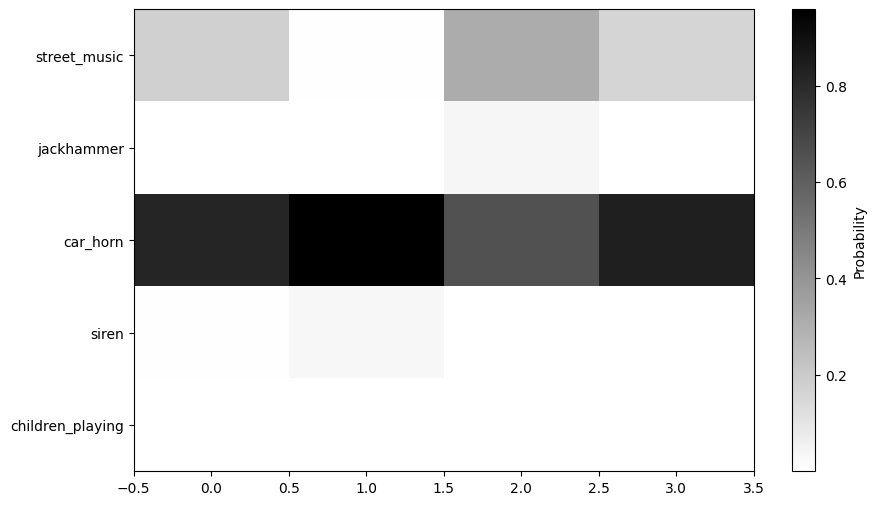

In [52]:
model_test.predict_with_explain(audio)